# III. Time series (part 1)
---
**Author(s):** Quentin Yeche, Kenji Ose, Dino Ienco - [UMR TETIS](https://umr-tetis.fr) / [INRAE](https://www.inrae.fr/)

---

## 1. Introduction
In this notebook we will introduce the time dimension into our exploration of data cubes. We will also cover handling masks, and specifically cloud cover masks, as well as the extraction of spectral signatures


### Outline

In [section 3](#3-getting-a-sentinel-2-image-time-series) we will be retrieving a Sentinel-2 time series from a STAC catalog.

In [section 4](#4-operations-on-the-time-dimension) we will learn about common operations on the time dimension

Finally in [section 5](#5-dealing-with-duplicate-dates) we will see how to deal with duplicate dates in a time series.

## 2. Library imports

As usual, we import all the required Python libraries.

In [1]:
# this cell is only useful if you're using an environment like Google Collab or
# Microsoft Planetary Computer's servers
def test_import_or_install(imports):
  import importlib
  restart_needed = False
  for import_name, pip_name in imports:
    try:
      importlib.import_module(import_name, package=None)
    except ModuleNotFoundError:
      if not restart_needed:
          restart_needed= True
          print('\033[91m' + ("ONE OR MORE LIBRARIES HAVE TO BE INSTALLED, "
          "PLEASE RESTART THE NOTEBOOK AFTER THIS CELL FINISHES EXECUTING "
          "TO ENSURE PROPER FUNCTIONALITY") + "\x1b[0m")
      %pip install {pip_name}
  if restart_needed:
    print('\033[91m' + ("LIBRARIES HAVE BEEN INSTALLED. "
          "PLEASE RESTART THE NOTEBOOK NOW ") + "\x1b[0m")

imports = [('pystac_client', 'pystac-client'),
           ('planetary_computer', 'planetary-computer'),
           ('stackstac', 'stackstac'),
           ]

test_import_or_install(imports)

In [2]:
# STAC access
import pystac_client
import planetary_computer

# dataframes
import pandas as pd

# xarrays
import xarray as xr

# library for turning STAC objects into xarrays
import stackstac

# visualization
from matplotlib import pyplot as plt

# miscellanous
import numpy as np
from IPython.display import display
from datetime import date
from dateutil.relativedelta import relativedelta

## 3. Getting a Sentinel-2 image time series

### 3.1. Request on a STAC catalog

As a practical use case let's consider that we have identified the STAC Collection we're interested in (see [this notebook](01-STAC.ipynb) for a refresher), and we also have an area of interest defined as a bounding box.

In [3]:
aoi_bounds = (3.875107329166124, 43.48641456618909, 4.118824575734205, 43.71739887308995)

# retrieving the relevant STAC Item
catalog = pystac_client.Client.open(
    "https://planetarycomputer.microsoft.com/api/stac/v1",
    modifier=planetary_computer.sign_inplace,
    )

time_range = f"2020/2022"
search = catalog.search(
    collections=['sentinel-2-l2a'],
    datetime=time_range,
    bbox=aoi_bounds
)
items = search.item_collection()
print(f"{len(items)} items found")

425 items found


As a reminder, let's print out the assets description of the first item (or image):

In [4]:
item = items[0]
assets = [asset.title for asset in item.assets.values()]
descriptions = pd.DataFrame(assets, columns=['Description'],
                            index=pd.Series(item.assets.keys(), name='asset_key'))
descriptions

,Description
asset_key,
AOT,Aerosol optical thickness (AOT)
B01,Band 1 - Coastal aerosol - 60m
B02,Band 2 - Blue - 10m
B03,Band 3 - Green - 10m
B04,Band 4 - Red - 10m
B05,Band 5 - Vegetation red edge 1 - 20m
B06,Band 6 - Vegetation red edge 2 - 20m
B07,Band 7 - Vegetation red edge 3 - 20m
B08,Band 8 - NIR - 10m


> <span style='color:red'> **IMPORTANT:** The URLs that we obtain from the STAC Catalog are not valid indefinitely. They expire after about 30 minutes. If you see an error in the notebook, it is likely because the URL that you obtained by running the first few cells has now expired.</span> If that happens you should be able to just run the notebook again from the top to get a new URL. You can get longer-lasting URLs by signing up for Planetary Computer (which is free at the time of writing this notebook). More info [here](https://planetarycomputer.microsoft.com/docs/concepts/sas/). 

### 3.2. Creating a datacube from STAC search results

This process is very similar to what we did to create a DataArray in the beginning of the [previous notebook](03-Xarray.ipynb).

In [5]:
bands = ['B02', 'B03', 'B04', 'B05', 'B06', 'B07', 'B08', 'B11', 'B12']
array = stackstac.stack(
                    items,
                    assets = bands,
                    resolution=10,
                    bounds_latlon=aoi_bounds,
                    )
array 

<xarray.DataArray 'stackstac-eae2eda67ce9b78cc1d56b8f486fa799' (time: 425,
                                                                band: 9,
                                                                y: 2590, x: 1999)> Size: 158GB
dask.array<fetch_raster_window, shape=(425, 9, 2590, 1999), dtype=float64, chunksize=(1, 1, 1024, 1024), chunktype=numpy.ndarray>
Coordinates: (12/44)
  * time                                     (time) datetime64[ns] 3kB 2020-0...
    id                                       (time) <U54 92kB 'S2B_MSIL2A_202...
  * band                                     (band) <U3 108B 'B02' ... 'B12'
  * x                                        (x) float64 16kB 5.705e+05 ... 5...
  * y                                        (y) float64 21kB 4.841e+06 ... 4...
    instruments                              <U3 12B 'msi'
    ...                                       ...
    proj:bbox                                object 8B {4900020.0, 4790220.0,...
    title                                    (band) <U36 1kB 'Band 2 - Blue -...
    common_name                              (band) <U7 252B 'blue' ... 'swir22'
    center_wavelength                        (band) float64 72B 0.49 ... 2.19
    full_width_half_max                      (band) float64 72B 0.098 ... 0.242
    epsg                                     int64 8B 32631
Attributes:
    spec:        RasterSpec(epsg=32631, bounds=(570490, 4815200, 590480, 4841...
    crs:         epsg:32631
    transform:   | 10.00, 0.00, 570490.00|\n| 0.00,-10.00, 4841100.00|\n| 0.0...
    resolution:  10

We can see that in a few lines of code we have created a DataArray which data has a size in the tens of gigabytes. The idea of lazy computations and not downloading data until necessary starts to make a lot more sense with these sizes. When we also consider the fact our area of interest is only about 5% of a full Sentinel-2 tile, the ability to download only part of a tile also becomes very important. If we had to download the entire tiles before creating this array the volume of data would probably be measured in terabytes!

### 3.3. Checking for invalid values

Before moving on, it is always a good idea to check the validity of the DataArray we just created. There are two main things to check for:
 - The presence of fill values. As described in the [previous notebook](03-Xarray.ipynb), the fill value `np.nan` is used by `stackstac.stack` in order to replace missing STAC Assets.
 - The presence of NODATA pixels. In our case (Sentinel-2) pixel values of 0 are used to flag that the pixel does not contain valid data.

Of course, checking for these values necessitate to download the data. Thus we can really only look at a sample.

In [6]:
# we're only taking the first 4 dates
sample = array.isel(time=slice(0,4))
fill_values = sample.isnull().sum().values

print(f"Data contains {fill_values} fill value pixels")


Data contains 0 fill value pixels


As expected we see no fill values. Indeed we have no missing Asset in any of our Items. Our collection of STAC Items is homogenous, all Sentinel-2 Items contain the right Assets.

### 3.3.2 Checking for NODATA

There are two situations in which NODATA pixels can appear. The first is extents which do not strictly overlap. Satellite images are almost always distributed as multi-dimensional array with a rectangular shape. If the bounds do not exactly match then the image is completed with NODATA values to make up a rectangular shape.


<figure align="center">
  <img src="resources/extent_nodata.png" width="30%" alt="STAC Item diagram">
  <figcaption>Sentinel-2 image with NODATA values
  </figcaption>
</figure>

The second situation where NODATA values can appear is when some pixels are flagged as invalid despite being inside the boundaries of the area being captured by the captor. Typically the amount of such invalid pixels is very low.

---
> **Exercise**
1. Find the percentage of NODATA pixels with the two following methods:
  - Using `sample` and `xr.where`
  - Using the temporal mean of the `s2:nodata_pixel_percentage` metadata field (you can use `np.mean`).
2. Conlude.

In [7]:
# to fill
# TOREMOVE

no_data = xr.where(sample == 0, 1, 0).sum().values
no_data_meta = np.mean(sample["s2:nodata_pixel_percentage"].values)
print(f"{no_data/sample.size:.1%} of values are NODATA using the sample and {no_data_meta:.1f}% using metadata")

49.1% of values are NODATA using the sample and 44.1% using metadata


<details>
<summary><b>Explanation</b></summary>

>We can see that almost half of the pixels in the sample are invalid. So it appears that at least some our images do not fully overlap with our area of interest.
> The first thing we can look at is the `s2:nodata_pixel_percentage`. It gives us the percentage of pixels with NODATA in the tile for each date.
> <span style='color:red'> **IMPORTANT:**</span> Planetary Computer provides a few metadata properties along with the data.
 For Sentinel-2 the most useful include:
 > - `s2:nodata_pixel_percentage`
 > - `s2:water_percentage`
 > - `s2:vegetation_percentage`
 > - `eo:cloud_cover`
 > - `s2:high_proba_clouds_percentage`
 > - `s2:cloud_shadow_percentage`
>However <span style='color:red'> **these values were computed from the whole tile (an area of up to 110 x 110 km²), and they are NOT updated when only a sub-section of a tile is considered or downloaded**</span>. The values can still be used as a proxy or rough estimate without having to download the data. It is particularly useful when gathering data in order to decide what to keep or throw out. But be careful not to confuse them with the actual value which can be computed from a sub-section of a tile. For instance a Sentinel-2 tile could have a low value for `eo:cloud_cover`, indicating that there are relatively few clouds in the whole tile. But that doesn't mean that our area of interest could not contain some of these few clouds, leading to unusable data.
---
</details>

Let's look more closely at the `s2:nodata_pixel_percentage` field for each date:

In [8]:
[f'{pct:.2f} %' for pct in sample['s2:nodata_pixel_percentage']]

['3.37 %', '86.80 %', '0.00 %', '86.40 %']

Half the dates have more than 85% of their pixels labelled as NODATA, while the others have few to none. Let's see if this behavior applies to the whole data cube:

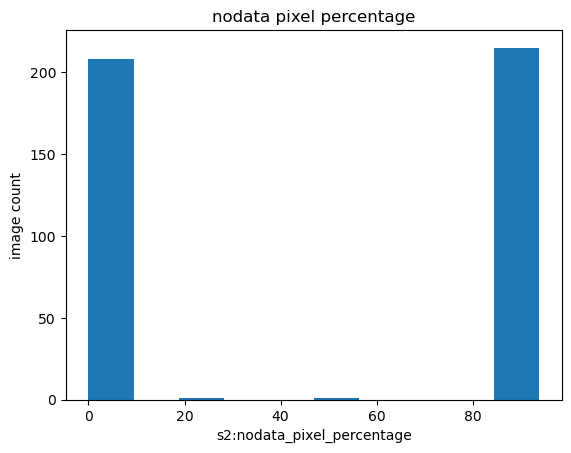

In [9]:
array['s2:nodata_pixel_percentage'].plot.hist()
plt.title('nodata pixel percentage')
plt.ylabel('image count')
plt.show()

It appears that we are dealing with two different types Sentinel-2 images, one of which only has a small amount of valid values. We can know more by looking at the `sat:relative_orbit` coordinate of our array. It gives us the number of the orbit during which the image was captured:

---
> **Exercise**
> * Using the `sat:relative_orbit` field, find all the existing orbit values within the datacube (Hint: `np.unique` works well with `xarray`).
> * Find a relation between the following metadata: `s2:nodata_pixel_percentage` and `sat:relative_orbit`. A histogram may be useful here.

In [10]:
# to fill
# TOREMOVE

print(f"The 'sat:relative_orbit' metadata can take the \
following values : {list(np.unique(array['sat:relative_orbit']))}")

The 'sat:relative_orbit' metadata can take the following values : [8, 108]


The images were captured with two different orbits: 8 and 108. Let's plot the same histogram as before, but discriminating between the two orbits:

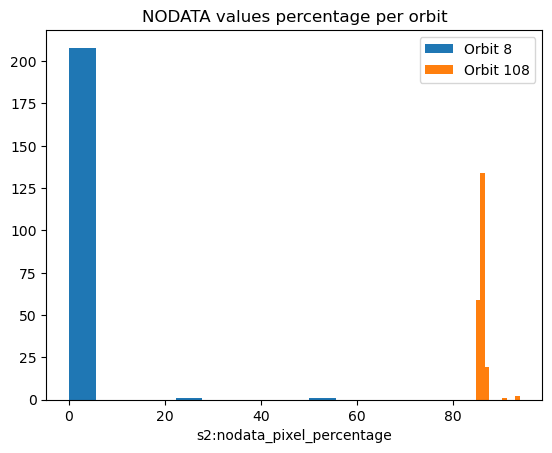

In [11]:
array.sel(time=array.time['sat:relative_orbit']==8)['s2:nodata_pixel_percentage'].plot.hist()
array.sel(time=array.time['sat:relative_orbit']==108)['s2:nodata_pixel_percentage'].plot.hist()
plt.legend(['Orbit 8', 'Orbit 108'])
plt.title('NODATA values percentage per orbit')
plt.show()

#TO REMOVE

---

As suspected, one of the two orbits is mainly at fault: orbit 108. However, let's keep in mind that these values we're looking at from `s2:nodata_pixel_percentage` are for the whole satellite image which corresponds to a much bigger area than ours. But at this point there is little chance that our area happens to overlap with this small portion of valid pixels.

We can check it with a similar test to what we did for the fill values:

In [12]:
# selecting from our sample the dates with orbit 108
sample_108 = sample.sel(time=sample.time['sat:relative_orbit']==108)

# counting the number of NODATA pixels as a percentage
# of overall pixel count
nodata_108 = xr.where(sample_108==0,1,0).sum().values
print(f"{nodata_108/sample_108.size:.1%} of pixels in the array are NODATA")

98.1% of pixels in the array are NODATA


Our area of interest falls almost entirely outside of the area of validity for the images with orbit 108. Thus we need to simply restrict our study to orbit 8.

In [13]:
array = array.sel(time=array.time['sat:relative_orbit']==8)
array

<xarray.DataArray 'stackstac-eae2eda67ce9b78cc1d56b8f486fa799' (time: 210,
                                                                band: 9,
                                                                y: 2590, x: 1999)> Size: 78GB
dask.array<getitem, shape=(210, 9, 2590, 1999), dtype=float64, chunksize=(1, 1, 1024, 1024), chunktype=numpy.ndarray>
Coordinates: (12/44)
  * time                                     (time) datetime64[ns] 2kB 2020-0...
    id                                       (time) <U54 45kB 'S2B_MSIL2A_202...
  * band                                     (band) <U3 108B 'B02' ... 'B12'
  * x                                        (x) float64 16kB 5.705e+05 ... 5...
  * y                                        (y) float64 21kB 4.841e+06 ... 4...
    instruments                              <U3 12B 'msi'
    ...                                       ...
    proj:bbox                                object 8B {4900020.0, 4790220.0,...
    title                                    (band) <U36 1kB 'Band 2 - Blue -...
    common_name                              (band) <U7 252B 'blue' ... 'swir22'
    center_wavelength                        (band) float64 72B 0.49 ... 2.19
    full_width_half_max                      (band) float64 72B 0.098 ... 0.242
    epsg                                     int64 8B 32631
Attributes:
    spec:        RasterSpec(epsg=32631, bounds=(570490, 4815200, 590480, 4841...
    crs:         epsg:32631
    transform:   | 10.00, 0.00, 570490.00|\n| 0.00,-10.00, 4841100.00|\n| 0.0...
    resolution:  10

In the previous histograms we could see that even with orbit 8 there were a few values with higher than average amounts of invalid pixels:

In [14]:
array.sel(time=array.time['s2:nodata_pixel_percentage']>5)

<xarray.DataArray 'stackstac-eae2eda67ce9b78cc1d56b8f486fa799' (time: 3,
                                                                band: 9,
                                                                y: 2590, x: 1999)> Size: 1GB
dask.array<getitem, shape=(3, 9, 2590, 1999), dtype=float64, chunksize=(1, 1, 1024, 1024), chunktype=numpy.ndarray>
Coordinates: (12/44)
  * time                                     (time) datetime64[ns] 24B 2020-0...
    id                                       (time) <U54 648B 'S2A_MSIL2A_202...
  * band                                     (band) <U3 108B 'B02' ... 'B12'
  * x                                        (x) float64 16kB 5.705e+05 ... 5...
  * y                                        (y) float64 21kB 4.841e+06 ... 4...
    instruments                              <U3 12B 'msi'
    ...                                       ...
    proj:bbox                                object 8B {4900020.0, 4790220.0,...
    title                                    (band) <U36 1kB 'Band 2 - Blue -...
    common_name                              (band) <U7 252B 'blue' ... 'swir22'
    center_wavelength                        (band) float64 72B 0.49 ... 2.19
    full_width_half_max                      (band) float64 72B 0.098 ... 0.242
    epsg                                     int64 8B 32631
Attributes:
    spec:        RasterSpec(epsg=32631, bounds=(570490, 4815200, 590480, 4841...
    crs:         epsg:32631
    transform:   | 10.00, 0.00, 570490.00|\n| 0.00,-10.00, 4841100.00|\n| 0.0...
    resolution:  10

Feel free to take a look at these dates and their data to decide whether they should be kept. Let's just decide to remove them, as this is only a handful of dates.

In [15]:
array = array.sel(time=array.time['s2:nodata_pixel_percentage'] <5)
array

<xarray.DataArray 'stackstac-eae2eda67ce9b78cc1d56b8f486fa799' (time: 207,
                                                                band: 9,
                                                                y: 2590, x: 1999)> Size: 77GB
dask.array<getitem, shape=(207, 9, 2590, 1999), dtype=float64, chunksize=(1, 1, 1024, 1024), chunktype=numpy.ndarray>
Coordinates: (12/44)
  * time                                     (time) datetime64[ns] 2kB 2020-0...
    id                                       (time) <U54 45kB 'S2B_MSIL2A_202...
  * band                                     (band) <U3 108B 'B02' ... 'B12'
  * x                                        (x) float64 16kB 5.705e+05 ... 5...
  * y                                        (y) float64 21kB 4.841e+06 ... 4...
    instruments                              <U3 12B 'msi'
    ...                                       ...
    proj:bbox                                object 8B {4900020.0, 4790220.0,...
    title                                    (band) <U36 1kB 'Band 2 - Blue -...
    common_name                              (band) <U7 252B 'blue' ... 'swir22'
    center_wavelength                        (band) float64 72B 0.49 ... 2.19
    full_width_half_max                      (band) float64 72B 0.098 ... 0.242
    epsg                                     int64 8B 32631
Attributes:
    spec:        RasterSpec(epsg=32631, bounds=(570490, 4815200, 590480, 4841...
    crs:         epsg:32631
    transform:   | 10.00, 0.00, 570490.00|\n| 0.00,-10.00, 4841100.00|\n| 0.0...
    resolution:  10

### 3.3.4 Extra: The relationship between Sentinel-2 tiles and orbits

Sentinel-2 utilizes the concept of tiles. A Sentinel-2 tile delimits an area of 100x100 km². Each tile has a unique code. The tile that our area of interest falls in is the tile 31TEJ (oftentimes the T is added in front: T31TEJ). 

> **Note:** As an aside this code can be found in `s2:mgrs_tile` and as part of the `s2:granule_id` coordinate of our array. More information on the naming conventions used by Sentinel-2 can be found [here](https://sentinels.copernicus.eu/web/sentinel/user-guides/sentinel-2-msi/naming-convention#:~:text=The%20top%2Dlevel%20SENTINEL%2D2,separated%20by%20an%20underscore%20(_).&text=The%20Mission%20Identifier%20(MMM)%20denotes,for%20the%20SENTINEL%2D2B%20instrument.).

In order to capture an image in the area delimited by the tile 31TEJ the satellite has to fly over the area along an orbit. For tile 31TEJ this orbit is orbit 8. But in order to ensure that there exists overlap between the tiles, data is actually captured with some overlap in a 110x110 km² area. 

Here is now the explanation for the two orbits. The images we see with orbit 108 actually correspond to the acquisition for a different, neighboring tile 31TJG. But since there is overlap between the two images, a small area near the edge of tile 31TEJ is covered by the acquisitions made with orbit 108.

> **Note:** A useful interactive map of the Sentinel-2 tiling grid is available [here](https://eatlas.org.au/data/uuid/f7468d15-12be-4e3f-a246-b2882a324f59) (it can take a few seconds for the map to load in completely). It clearly shows the different tiles, their codes and the overlap between them.

## 4. Operations on the time dimension

In the [previous notebook](02-Single-date.ipynb) we covered how to manipulate Xarrays. Now that we have introduced multiple dates in our time dimension, there are a few more tools which are useful when dealing with temporal data.

### 4.1. Pandas dates and inexact matching

There are situations in which having to match the exact values is not desirable. Date objects are usually given with a high degree of precision, and it is not practical having to always specify hours minutes and seconds in situations where the date would suffice. There are a few things which help alleviate this annoyance.

The first is that Xarray uses the same logic as pandas for its date indexes. Even though the values are datetime64 objects, they can be selected with regular strings for convenience. For instance "`2023`" will correctly match all datetime64 objects between `2023-01-01T00:00:00` and `2023-12-31T23:59:59`, and `2023-01` will correctly match all datetime64 objects of the January 2023, etc.

The other tool is the ability of the `sel` method to select inexact matches. This behavior is not limited to time dimensions, but it is particularly applicable for dates. By default, `sel` only matches exact values. However the `method` parameter can enable inexact matches:
 - `pad` or `ffill` will match the nearest value below
 - `backfill` or `bfill` will match the nearest value above
 - `nearest` will match the nearest value

 Another parameter of `sel` is `tolerance`. It allows to set a limit on the distance between the specified value and a possible match. For dates it can used with a `timedelta64` objet or a string like `'5D'` (5 days), `'5M3W'` (5 months 3 weeks), `'2Y15h34s'`(2 years 15 hours and 34 seconds), etc.


In [16]:
few_dates = array.isel(time=slice(3,7)).time
print(f"Dates:\n {few_dates.values}")

# does not match the last date as it is in February
print(f"\n2020-01: \n {few_dates.sel(time='2020-01').values}")

# matches 2020-01-18 as it is the nearest
print(f"\nnearest 2020-01-18 \n",
      f"{few_dates.sel(time='2020-01-20', method='nearest').values}")

# matches 2020-01-23 as it is the nearest date after 2020-01-20
print(f"\nbackfill 2020-01-18\n",
      f"{few_dates.sel(time='2020-01-20', method='backfill').values}")

# matches 2020-01-18 as it is the nearest date before 2020-01-22
print(f"\npad 2020-01-22 \n",
      f"{few_dates.sel(time='2020-01-22', method='pad').values}")

# 2020-01-23 is treated as 2020-01-23T00:00:00
# which comes before 2020-01-23T10:42:29.0240
# thus 2020-01-18 is the correct match
print(f"\npad 2023-01-22\n",
      f"{few_dates.sel(time='2020-01-23', method='pad').values}")

print(f"\npad 2023-01-22 with tolerance 4 days 14 hours\n",
      f"{few_dates.sel(time='2020-01-23', method='pad', tolerance='4D14h').values}")

# this one would fail to get a match and give an error
#print(f"\npad 2023-01-22 with tolerance 4 days 13 hours and 5 seconds\n",
#      f"{few_dates.sel(time='2020-01-23', method='pad', tolerance='4D13h5s').values}")

Dates:
 ['2020-01-18T10:43:51.024000000' '2020-01-23T10:42:29.024000000'
 '2020-01-28T10:43:01.024000000' '2020-02-02T10:41:49.024000000']

2020-01: 
 ['2020-01-18T10:43:51.024000000' '2020-01-23T10:42:29.024000000'
 '2020-01-28T10:43:01.024000000']

nearest 2020-01-18 
 2020-01-18T10:43:51.024000000

backfill 2020-01-18
 2020-01-23T10:42:29.024000000

pad 2020-01-22 
 2020-01-18T10:43:51.024000000

pad 2023-01-22
 2020-01-18T10:43:51.024000000

pad 2023-01-22 with tolerance 4 days 14 hours
 2020-01-18T10:43:51.024000000


Another thing inherited from pandas is the `dt` accessor. It allows accessing specific components of a datetime64 object. The full list of components can be found [here](https://pandas.pydata.org/docs/user_guide/timeseries.html#time-date-components).

In [17]:
# all the data from February for all the years
array.sel(time=(array.time.dt.month == 2))

# all the data captured on the 4th day of a month
array.sel(time=(array.time.dt.day == 4))

<xarray.DataArray 'stackstac-eae2eda67ce9b78cc1d56b8f486fa799' (time: 6,
                                                                band: 9,
                                                                y: 2590, x: 1999)> Size: 2GB
dask.array<getitem, shape=(6, 9, 2590, 1999), dtype=float64, chunksize=(1, 1, 1024, 1024), chunktype=numpy.ndarray>
Coordinates: (12/44)
  * time                                     (time) datetime64[ns] 48B 2020-0...
    id                                       (time) <U54 1kB 'S2A_MSIL2A_2020...
  * band                                     (band) <U3 108B 'B02' ... 'B12'
  * x                                        (x) float64 16kB 5.705e+05 ... 5...
  * y                                        (y) float64 21kB 4.841e+06 ... 4...
    instruments                              <U3 12B 'msi'
    ...                                       ...
    proj:bbox                                object 8B {4900020.0, 4790220.0,...
    title                                    (band) <U36 1kB 'Band 2 - Blue -...
    common_name                              (band) <U7 252B 'blue' ... 'swir22'
    center_wavelength                        (band) float64 72B 0.49 ... 2.19
    full_width_half_max                      (band) float64 72B 0.098 ... 0.242
    epsg                                     int64 8B 32631
Attributes:
    spec:        RasterSpec(epsg=32631, bounds=(570490, 4815200, 590480, 4841...
    crs:         epsg:32631
    transform:   | 10.00, 0.00, 570490.00|\n| 0.00,-10.00, 4841100.00|\n| 0.0...
    resolution:  10

### 4.2. Resampling and other operations

#### 4.2.1. Analyzing acquisition frequencies

What follows are a few examples of operations on dates in order to extract useful information. They can be instrumental in refining a time series. It is technically possible to do more complex operations like upsampling and interpolation, but they will not be covered here.

First, we create a function to format axes for dates as a fairly readable year/month string:


In [18]:
# this function is used to format axes for dates
# as a fairly readable year/month standard
def date_format(ax, month='%B'):
    import matplotlib.dates as mdates
    # adding locations and formatting for months
    # on the x axis
    loc = mdates.MonthLocator(bymonth=(1,4,7,10))
    major_fmt = mdates.ConciseDateFormatter(loc,
                formats=['%Y', month, '%d', '%H:%M', '%H:%M', '%S.%f']
                                            )
    ax.xaxis.set_major_formatter(major_fmt)
    ax.xaxis.set_major_locator(loc)

    # adding minor ticks for months without a label
    ax.xaxis.set_minor_locator(mdates.MonthLocator())

Then we calculate and plot the number of days between each acquisition to see if there are any gaps:

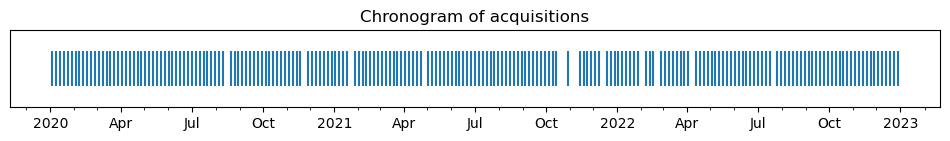

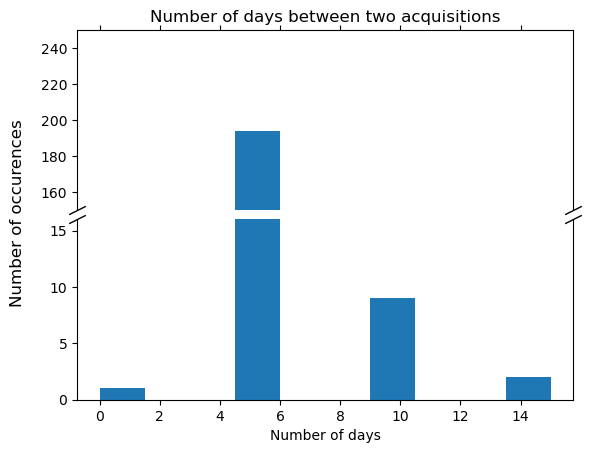

In [19]:
# calculating the number of days between each acquisition
# to see if there are gaps
fig, ax = plt.subplots(figsize=(12,1))
ax.eventplot(array.time)
ax.set_title("Chronogram of acquisitions")

date_format(ax, month='%b')

# removing y axis ticks as they are meaningless
ax.set_yticks([])
fig.show()

# plotting as a histogram
fig, (ax1, ax2) = plt.subplots(2,1, sharex=True)
ax1.hist(array.time.diff(dim='time').dt.round('1D').dt.days)
ax2.hist(array.time.diff(dim='time').dt.round('1D').dt.days)
fig.subplots_adjust(hspace=0.05)
ax1.set_ylim(150,250)
ax2.set_ylim(0,16)

ax1.spines.bottom.set_visible(False)
ax2.spines.top.set_visible(False)
ax1.xaxis.tick_top()
ax2.xaxis.tick_bottom()

# adding cut-out slanted lines to signify a cut in the y axis
d = .5
kwargs = dict(marker=[(-1, -d), (1, d)], markersize=12,
              linestyle="none", color='k', mec='k', mew=1, clip_on=False)
ax1.plot([0, 1], [0, 0], transform=ax1.transAxes, **kwargs)
ax2.plot([0, 1], [1, 1], transform=ax2.transAxes, **kwargs)

ax1.set_title('Number of days between two acquisitions')
ax2.set_xlabel('Number of days')
# supylabel allows us to name both y axes together
fig.supylabel("Number of occurences")
plt.show()

fig.show()


We also can count the number of acquisitions per month:

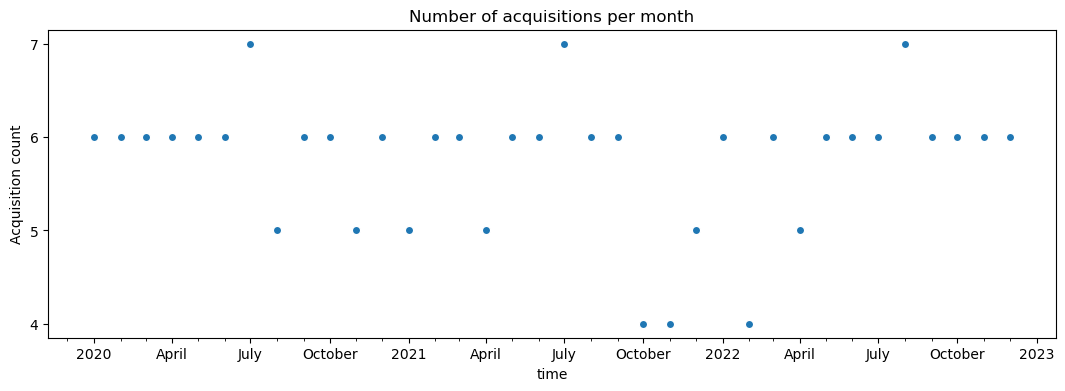

In [20]:
# counting the number of acquisitons per month

# resampling and counting for each month
# using MS (Month Start) as we prefer using the first day
# of the month as a reference point instead of the last
# acquisition date of the month
ar = array.time.resample(time='MS').count()

import matplotlib.dates as mdates
fig, ax = plt.subplots(figsize=(13,4))
ar.plot.scatter(ax=ax, x='time')
ax.set_ylabel('Acquisition count')
ax.set_title("Number of acquisitions per month")

# setting y ticks manually to avoid non-integer values being used
ax.set_yticks(range(ar.min().values, ar.max().values+1))

date_format(ax)
fig.show()

#### 4.2.2. Analyzing variations of cloud cover

To finish things up, let's plot the evolution of vegetation and cloud cover percentage over time as given by `s2:vegetation_percentage` and `eo:cloud_cover` respectively. Remember, these values are actually for a bigger area than ours, but trends should usually be correct.



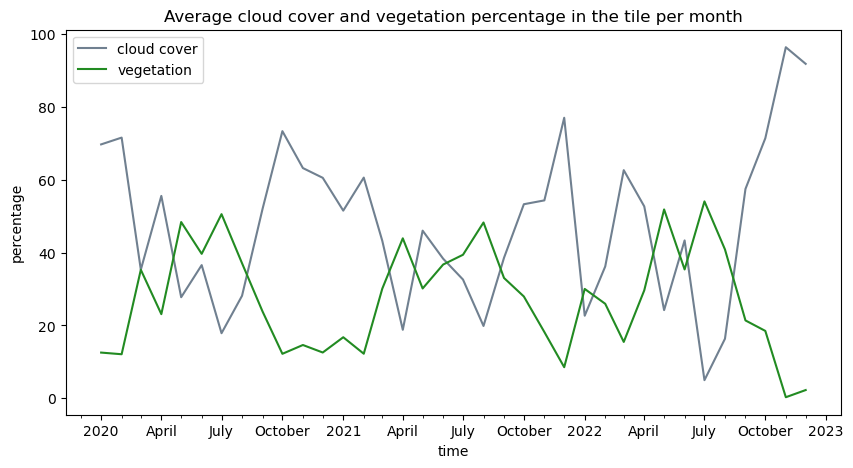

In [33]:
fig, ax = plt.subplots(figsize=(10,5))
# MS refers to Month Start (Month End is also possible, but rarely preferable)
array['eo:cloud_cover'].resample(time='MS').mean().plot(ax=ax, color='slategrey')
array['s2:vegetation_percentage'].resample(time='MS').mean().plot(ax=ax, color='forestgreen')
ax.legend(['cloud cover', 'vegetation'])
ax.set_ylabel('percentage')
ax.set_title('Average cloud cover and vegetation percentage in the tile per month')

date_format(ax)

fig.show()

Naturally both plots are very negatively correlated since 'cloudy' and 'vegetation'  are two exclusive classes for a pixel.

## 5. Extra: Dealing with duplicate dates

When dealing with time series it is rare but possible to encounter duplicated acquisition dates. With Sentinel-2 data there are two situations where this can happen:
 1. The acquisition is spatially split. One packet has one part of the geometry and the other packet has the rest. Solving this requires manually looking at the extents and possibly having to fuse them.
 2. The data was re-released after being reprocessed. The acquisition date is the same but the processing date is not the same. Unfortunately the processing date is not directly available on STAC, but it can still be found within the `s2:product_uri` property. Along other things this string contains two dates. The first is the acquisition date (the same as what can be found in the `time` dimension) and the second is the date of when the data was processed. In this situation it is typically preferable to use the reprocessed data (as there should be a good reason for the reprocessing), but sometimes the data is actually identical despite the reprocessing.

What follows is one of the ways to detect and deal with duplicates:

In [22]:
# the easiest way to find duplicates is to extract the pandas index
# from the xarray with .indexes and calling the duplicated method
# keep=False makes it so that all all duplicates are flagged instead
# of all duplicates but the first/last
duplicate_indexes = array.indexes['time'].duplicated(keep=False)
duplicates = array.sel(time=duplicate_indexes)
duplicates

<xarray.DataArray 'stackstac-eae2eda67ce9b78cc1d56b8f486fa799' (time: 2,
                                                                band: 9,
                                                                y: 2590, x: 1999)> Size: 746MB
dask.array<getitem, shape=(2, 9, 2590, 1999), dtype=float64, chunksize=(1, 1, 1024, 1024), chunktype=numpy.ndarray>
Coordinates: (12/44)
  * time                                     (time) datetime64[ns] 16B 2022-0...
    id                                       (time) <U54 432B 'S2B_MSIL2A_202...
  * band                                     (band) <U3 108B 'B02' ... 'B12'
  * x                                        (x) float64 16kB 5.705e+05 ... 5...
  * y                                        (y) float64 21kB 4.841e+06 ... 4...
    instruments                              <U3 12B 'msi'
    ...                                       ...
    proj:bbox                                object 8B {4900020.0, 4790220.0,...
    title                                    (band) <U36 1kB 'Band 2 - Blue -...
    common_name                              (band) <U7 252B 'blue' ... 'swir22'
    center_wavelength                        (band) float64 72B 0.49 ... 2.19
    full_width_half_max                      (band) float64 72B 0.098 ... 0.242
    epsg                                     int64 8B 32631
Attributes:
    spec:        RasterSpec(epsg=32631, bounds=(570490, 4815200, 590480, 4841...
    crs:         epsg:32631
    transform:   | 10.00, 0.00, 570490.00|\n| 0.00,-10.00, 4841100.00|\n| 0.0...
    resolution:  10

At this point we know that there are duplicated dates in the time series. We could look manually and see that they correspond to two different dates having each 2 acquisitions listed. In particular by looking at `s2:product_uri` we can see that the processing dates are different.

However we can also do this programmatically:

In [23]:
dup_groups = duplicates.groupby('time')
# counting for each group the number of elements in the `time`
# dimension
dup_groups.count().isel(x=0, y=0, band=0).compute()

<xarray.DataArray 'stackstac-eae2eda67ce9b78cc1d56b8f486fa799' (time: 1)> Size: 8B
array([2])
Coordinates: (12/18)
    band                                     <U3 12B 'B02'
    x                                        float64 8B 5.705e+05
    y                                        float64 8B 4.841e+06
    instruments                              <U3 12B 'msi'
    constellation                            <U10 40B 'Sentinel 2'
    proj:epsg                                int64 8B 32631
    ...                                       ...
    title                                    <U36 144B 'Band 2 - Blue - 10m'
    common_name                              <U7 28B 'blue'
    center_wavelength                        float64 8B 0.49
    full_width_half_max                      float64 8B 0.098
    epsg                                     int64 8B 32631
  * time                                     (time) datetime64[ns] 8B 2022-08...
Attributes:
    spec:        RasterSpec(epsg=32631, bounds=(570490, 4815200, 590480, 4841...
    crs:         epsg:32631
    transform:   | 10.00, 0.00, 570490.00|\n| 0.00,-10.00, 4841100.00|\n| 0.0...
    resolution:  10

Now that we have our duplicated dates with each date in its group we can check whether the data is actually different. We use the `apply` method which allows to apply a function to each group separately.

What the function `lambda x: np.all(x==x[0])` does is to check whether all dates in the group have all their pixel values equal to the ones of the first date (`x[0]`) of the group.

In [24]:
dup_groups.apply(lambda x: np.all(x==x[0])).compute()

<xarray.DataArray 'stackstac-eae2eda67ce9b78cc1d56b8f486fa799' (time: 1)> Size: 1B
array([False])
Coordinates:
    instruments                              <U3 12B 'msi'
    constellation                            <U10 40B 'Sentinel 2'
    proj:epsg                                int64 8B 32631
    s2:datatake_type                         <U8 32B 'INS-NOBS'
    s2:saturated_defective_pixel_percentage  float64 8B 0.0
    s2:mgrs_tile                             <U5 20B '31TEJ'
    s2:product_type                          <U7 28B 'S2MSI2A'
    proj:bbox                                object 8B {4900020.0, 4790220.0,...
    epsg                                     int64 8B 32631
  * time                                     (time) datetime64[ns] 8B 2022-08...

In this case for both sets of duplicate dates the value is `True` which means that the duplicates are simply copies, thus it does not matter which copy is kept. Now we can simply call `drop_duplicates` to get unique dates in the time dimension

In [25]:
array.drop_duplicates(dim='time')

<xarray.DataArray 'stackstac-eae2eda67ce9b78cc1d56b8f486fa799' (time: 206,
                                                                band: 9,
                                                                y: 2590, x: 1999)> Size: 77GB
dask.array<getitem, shape=(206, 9, 2590, 1999), dtype=float64, chunksize=(1, 1, 1024, 1024), chunktype=numpy.ndarray>
Coordinates: (12/44)
  * time                                     (time) datetime64[ns] 2kB 2020-0...
    id                                       (time) <U54 44kB 'S2B_MSIL2A_202...
  * band                                     (band) <U3 108B 'B02' ... 'B12'
  * x                                        (x) float64 16kB 5.705e+05 ... 5...
  * y                                        (y) float64 21kB 4.841e+06 ... 4...
    instruments                              <U3 12B 'msi'
    ...                                       ...
    proj:bbox                                object 8B {4900020.0, 4790220.0,...
    title                                    (band) <U36 1kB 'Band 2 - Blue -...
    common_name                              (band) <U7 252B 'blue' ... 'swir22'
    center_wavelength                        (band) float64 72B 0.49 ... 2.19
    full_width_half_max                      (band) float64 72B 0.098 ... 0.242
    epsg                                     int64 8B 32631
Attributes:
    spec:        RasterSpec(epsg=32631, bounds=(570490, 4815200, 590480, 4841...
    crs:         epsg:32631
    transform:   | 10.00, 0.00, 570490.00|\n| 0.00,-10.00, 4841100.00|\n| 0.0...
    resolution:  10